## Modèle LSTM pour classification de texte

### Importation des bibliothèques nécessaires

In [15]:
# Importation des bibliothèques pour le traitement des données, les modèles et l'évaluation
import numpy as np
import pandas as pd
import time  # Pour mesurer les temps

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras pour le modèle LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn pour la division des données et les métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

### Chargement des données

In [16]:
# Chemins vers les fichiers de données et le modèle GloVe
data_path = "Data\\cleaned_data\\dataset_with_tokens.csv"
glove_model_path = "embeddings\\glove.6B.100d.txt"

# Chargement du dataset nettoyé
df = pd.read_csv(data_path)
print(f"Dataset chargé : {df.shape[0]} exemples")

Dataset chargé : 600 exemples


### Préparation des données

In [17]:
# Extraction des tokens et des labels
X = df["tokens"].apply(lambda x: x.split()).tolist()  # Liste de listes de tokens
y = df["label_encoded"].values  # Labels encodés : {'politics': 0, 'sport': 1, 'tech': 2}

print(f"Nombre d'exemples : {len(X)}")
print(f"Classes : {np.unique(y)} (0=Politics, 1=Sport, 2=Tech)")

Nombre d'exemples : 600
Classes : [0 1 2] (0=Politics, 1=Sport, 2=Tech)


### Division en ensembles d'entraînement et de validation

In [18]:
# Division stratifiée pour équilibrer les classes
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Entraînement : {len(X_train)} exemples")
print(f"Validation : {len(X_val)} exemples")

Entraînement : 480 exemples
Validation : 120 exemples


### Tokenisation et padding des séquences

In [19]:
# Paramètres pour la tokenisation
MAX_WORDS = 30000  # Taille maximale du vocabulaire
MAX_LEN = 100      # Longueur maximale des séquences

# Création et entraînement du tokenizer sur les données d'entraînement
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Conversion en séquences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding pour uniformiser la longueur
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post")

# Index des mots
word_index = tokenizer.word_index
print(f"Vocabulaire : {len(word_index)} mots uniques")

Vocabulaire : 11291 mots uniques


### Chargement des embeddings GloVe et création de la matrice d'embeddings

In [20]:
# Fonction pour charger les embeddings GloVe
def load_glove(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

# Chargement de GloVe
glove = load_glove(glove_model_path)
EMBEDDING_DIM = 100  # Dimension des embeddings

print(f"Embeddings GloVe chargés : {len(glove)} mots")

Embeddings GloVe chargés : 400000 mots


In [21]:
# Création de la matrice d'embeddings pour le vocabulaire
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Remplissage avec les vecteurs GloVe
for word, i in word_index.items():
    if i < num_words:
        vector = glove.get(word)  # Utilisation de glove au lieu d'embedding_index
        if vector is not None:
            embedding_matrix[i] = vector

print(f"Matrice d'embeddings créée : {embedding_matrix.shape}")

Matrice d'embeddings créée : (11292, 100)


### Construction du modèle LSTM bidirectionnel

In [22]:
# Nombre de classes
num_classes = len(np.unique(y))

# Construction du modèle
model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False  # Embeddings non entraînables (pré-entraînés)
    ),
    Bidirectional(LSTM(128)),  # LSTM bidirectionnel pour capturer le contexte
    Dropout(0.5),  # Régularisation
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")  # Sortie multiclasse
])

# Compilation du modèle
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1129200   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                      

### Entraînement du modèle

In [23]:
# Callback pour arrêter tôt si pas d'amélioration
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Mesure du temps d'entraînement
start_train = time.time()

# Entraînement
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

end_train = time.time()
train_time = end_train - start_train

print("Entraînement terminé")
print(f"Temps d'entraînement : {train_time:.2f} secondes")

Epoch 1/15
15/15 [==============================] - 7s 158ms/step - loss: 0.9561 - accuracy: 0.5083 - val_loss: 0.6446 - val_accuracy: 0.8417
Epoch 2/15
15/15 [==============================] - 1s 78ms/step - loss: 0.4008 - accuracy: 0.8792 - val_loss: 0.5759 - val_accuracy: 0.8333
Epoch 3/15
15/15 [==============================] - 1s 73ms/step - loss: 0.4438 - accuracy: 0.8583 - val_loss: 0.3101 - val_accuracy: 0.8667
Epoch 4/15
15/15 [==============================] - 1s 66ms/step - loss: 0.2607 - accuracy: 0.9312 - val_loss: 0.1938 - val_accuracy: 0.9167
Epoch 5/15
15/15 [==============================] - 1s 67ms/step - loss: 0.1682 - accuracy: 0.9438 - val_loss: 0.1661 - val_accuracy: 0.9333
Epoch 6/15
15/15 [==============================] - 1s 68ms/step - loss: 0.1394 - accuracy: 0.9500 - val_loss: 0.1626 - val_accuracy: 0.9500
Epoch 7/15
15/15 [==============================] - 1s 67ms/step - loss: 0.1270 - accuracy: 0.9646 - val_loss: 0.1781 - val_accuracy: 0.9417
Epoch 8/15
1

### Prédictions sur l'ensemble de validation

In [24]:
# Mesure du temps d'inférence
start_inf = time.time()

# Prédictions
y_val_probs = model.predict(X_val_pad)
y_val_pred = np.argmax(y_val_probs, axis=1)

end_inf = time.time()
inf_time = end_inf - start_inf

print(f"Prédictions générées pour {len(y_val_pred)} exemples")
print(f"Temps d'inférence : {inf_time:.2f} secondes")

4/4 [==============================] - 1s 23ms/step
Prédictions générées pour 120 exemples
Temps d'inférence : 1.36 secondes


### Évaluation des performances

In [25]:
# Métriques principales
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average="weighted")

print(f"Accuracy : {accuracy:.4f}")
print(f"F1-score (weighted) : {f1:.4f}")

Accuracy : 0.9500
F1-score (weighted) : 0.9502


In [26]:
# Matrice de confusion et rapport de classification
cm = confusion_matrix(y_val, y_val_pred)
print("Matrice de confusion :\n", cm)

print("Rapport de classification :")
print(classification_report(y_val, y_val_pred))

Matrice de confusion :
 [[38  1  1]
 [ 1 39  0]
 [ 3  0 37]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.97      0.97      0.97        40
           2       0.97      0.93      0.95        40

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



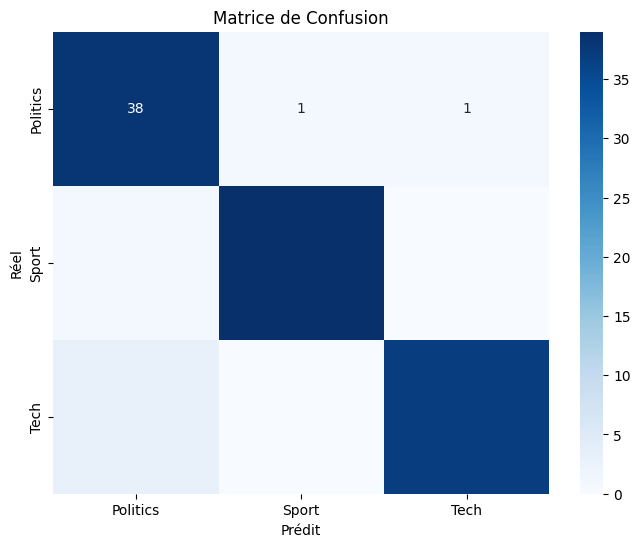

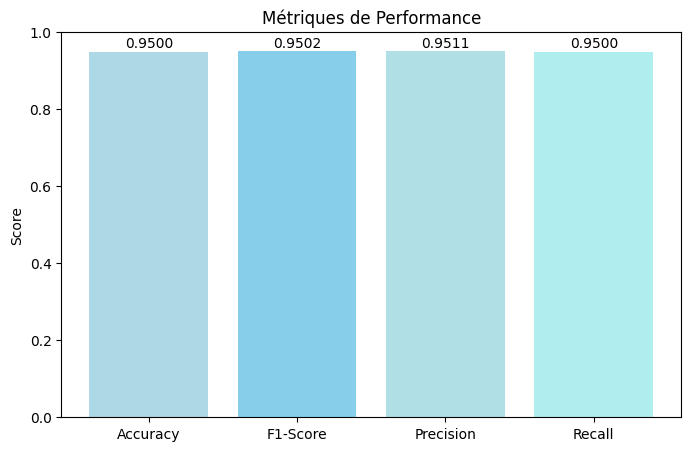

In [27]:
# Visualisations des performances

# Calcul des métriques supplémentaires
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Politics', 'Sport', 'Tech'], 
            yticklabels=['Politics', 'Sport', 'Tech'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Bar plot des métriques
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
values = [accuracy, f1, precision, recall]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['#ADD8E6', '#87CEEB', '#B0E0E6', '#AFEEEE'])  # Nuances douces de bleu
plt.ylim(0, 1)
plt.title('Métriques de Performance')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()